#### Setup

We load all the data required for creating the testbed

In [1]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect


import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections

from apoNN.src.occam import Occam
from apoNN.src.datasets import ApogeeDataset,AspcapDataset
from apoNN.src.utils import get_mask_elem,dump,load
from apoNN.src.plotting import summarize_representation
import apoNN.src.vectors as vector


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA,KernelPCA

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

[(['TEFF', 'LOGG', 'LOG10VDOP', 'METALS', 'C', 'N', 'O Mg Si S Ca Ti'], ['C', 'N', 'O', 'Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'V', 'Mn', 'Fe', 'Ni'], ['[C/M]', '[N/M]', '[O/M]', '[Na/H]', '[Mg/M]', '[Al/H]', '[Si/M]', '[S/M]', '[K/H]', '[Ca/M]', '[Ti/M]', '[V/H]', '[Mn/H]', '[Fe/H]', '[Ni/H]'], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])]


In [3]:
allStar =  load("allStar_training_clean")
dataset=  AspcapDataset(filename="aspcap_training_clean",tensor_type=torch.FloatTensor,recenter=True)
n_data=20000

In [4]:
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
n_outliercut = allStar["N_FE"]>-5
ni_outliercut = allStar["Ni_FE"]>-5
mn_outliercut = allStar["Mn_FE"]>-5


combined_cut = feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut & si_outliercut & n_outliercut & ni_outliercut & mn_outliercut


In [5]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE","Mn_FE","N_FE","Cr_FE"] 
y = vector.Vector(np.array([allStar[:n_data][combined_cut[:n_data]][param] for param in considered_parameters])[:,:n_data].T)
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)

### Preparing OCCAM data

In [6]:
occam = load("occam")
allStar_occam = occam["allStar"]
dataset_occam = AspcapDataset(filename="aspcap_occam",recenter=True,tensor_type=torch.FloatTensor,filling_dataset=dataset.dataset["aspcap"])

In [7]:
occam_cluster_idxs = occam["cluster_idxs"]


### PCA

In [8]:
compressor = PCA(n_components=15,whiten=False)#z.raw.shape[1],whiten=True)


In [9]:
compressor.fit(dataset.dataset["aspcap_interpolated"])

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
z_pca = compressor.transform(dataset.dataset["aspcap_interpolated"])
z_pca= z_pca[:n_data]
z = vector.Vector(z_pca[combined_cut[:n_data]],order=1,interaction_only=False)

In [11]:
reconstructed_dataset = compressor.inverse_transform(z_pca)

In [12]:
w = vector.LinearTransformation(z,y)


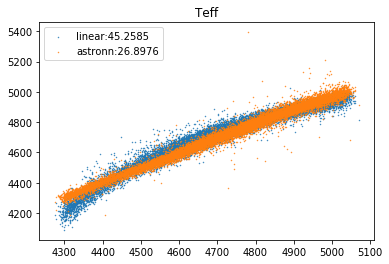

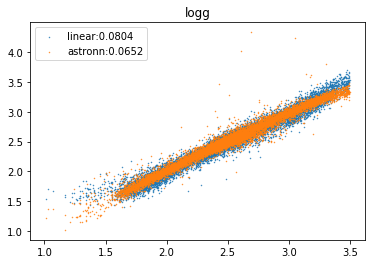

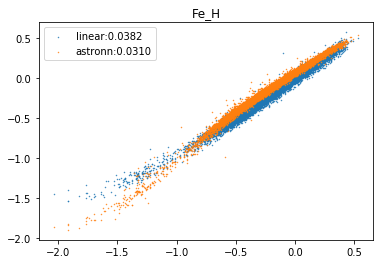

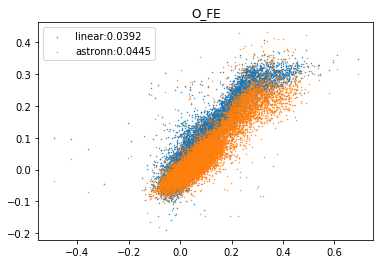

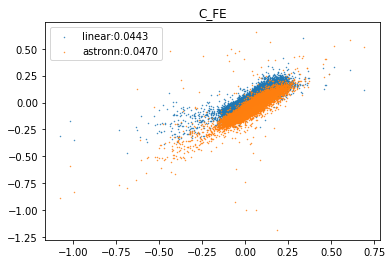

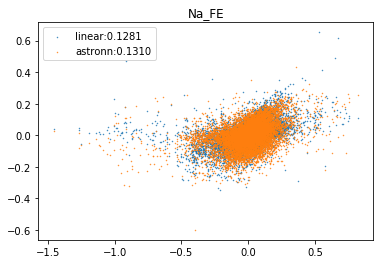

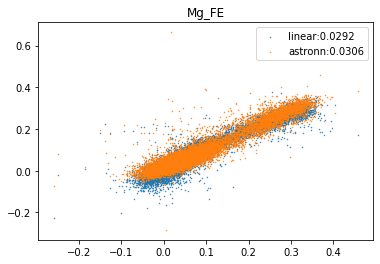

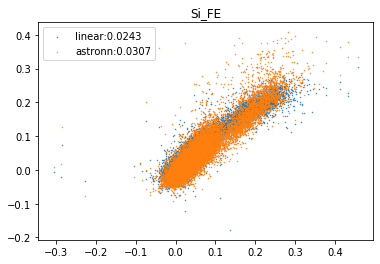

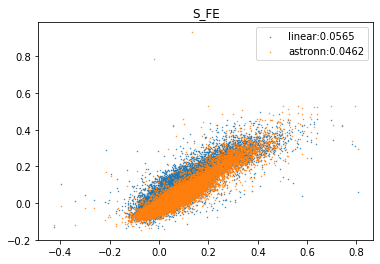

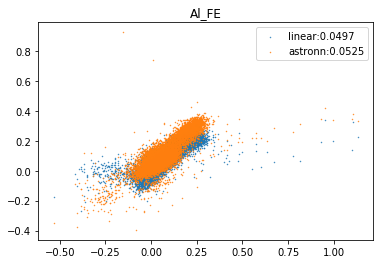

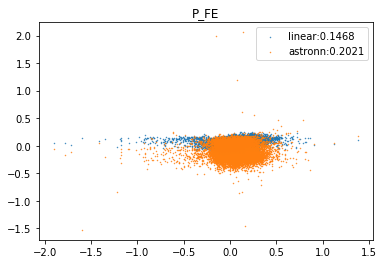

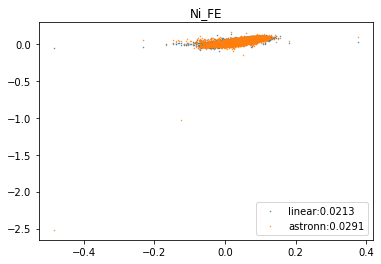

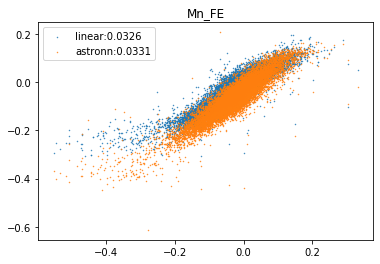

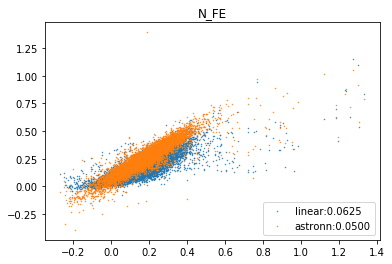

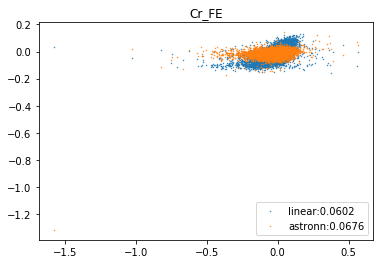

In [60]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

### Occam preparation

In [14]:
z_raw_occam = compressor.transform(dataset_occam.dataset["aspcap_interpolated"])
z_occam = vector.OccamLatentVector(occam_cluster_idxs,raw=z_raw_occam,order=1,interaction_only=False)

(array([6.95469962e-03, 3.99895366e-02, 2.45442962e-01, 1.56596680e+00,
        2.86446740e+00, 8.07614633e-01, 2.06902350e-01, 5.38989221e-02,
        4.05690951e-03, 2.89779151e-04]),
 array([-0.7514786 , -0.5789334 , -0.40638828, -0.2338431 , -0.06129793,
         0.11124724,  0.2837924 ,  0.45633757,  0.62888277,  0.8014279 ,
         0.9739731 ], dtype=float32),
 <a list of 10 Patch objects>)

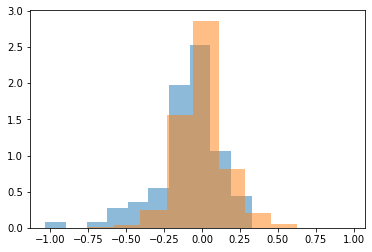

In [15]:
i=5
plt.hist(z_raw_occam[:,i],alpha=0.5,density=True)
plt.hist(z_pca[:,i],alpha=0.5,density=True)

### Whitening

In [16]:
whitener = PCA(n_components=z.raw.shape[1],whiten=True)#z.raw.shape[1],whiten=True)


In [17]:
whitener.fit(z.centered())

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [18]:
pca = PCA(n_components=z.raw.shape[1])
pca.fit(z_occam.cluster_centered.whitened(whitener)())

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [19]:
v =np.dot(pca.components_,z.centered.whitened(whitener)().T)
v_centered_occam =np.dot(pca.components_,z_occam.cluster_centered.whitened(whitener)().T)
v_occam =np.dot(pca.components_,z_occam.centered.whitened(whitener)().T)


In [66]:
np.dot(z.centered.whitened(whitener)(),pca.components_.T).shape


(15464, 15)

In [20]:
np.std(z.centered.whitened(whitener)().T,axis=1)

array([0.99996674, 0.9999656 , 0.9999663 , 0.99996704, 0.99996704,
       0.99996626, 0.999967  , 0.9999667 , 0.99996763, 0.9999679 ,
       0.99996793, 0.9999671 , 0.99996775, 0.99996614, 0.9999682 ],
      dtype=float32)

In [21]:
np.std(z_occam.cluster_centered.whitened(whitener)().T,axis=1)

array([0.53236064, 1.18521195, 0.77305102, 0.51899685, 0.83714581,
       0.91303583, 0.86628966, 1.17751852, 1.11681625, 1.22439103,
       1.16392688, 1.62250825, 1.78668071, 1.32467193, 1.11677843])

In [22]:
np.std(v_centered_occam,axis=1)

array([2.53406888, 2.01177254, 1.50167732, 1.21800912, 1.09269911,
       1.03213604, 0.87347831, 0.80233781, 0.61330443, 0.5232034 ,
       0.45024539, 0.40801765, 0.35747257, 0.30473019, 0.20335333])

occam: 0.020257013770562715
raw: 0.5159050203342201
ratio: 25.467970065949604


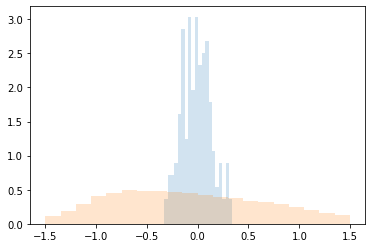

In [25]:
i=14
summarize_representation(v[i],v_centered_occam[i],0.1,0.1)


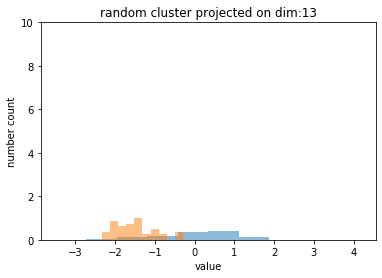

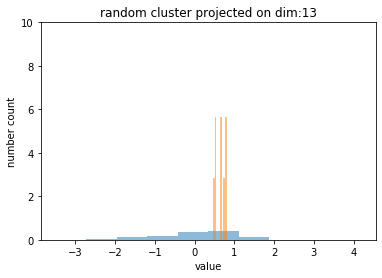

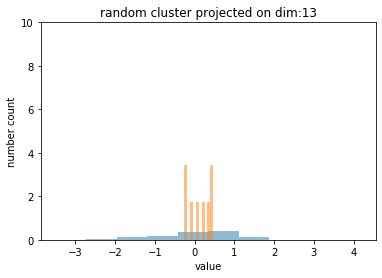

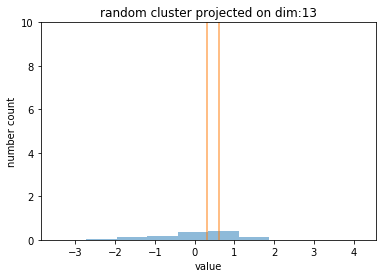

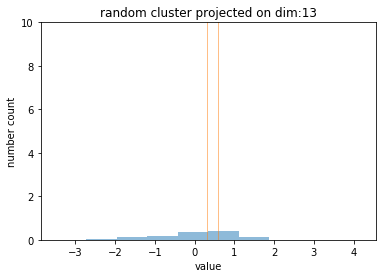

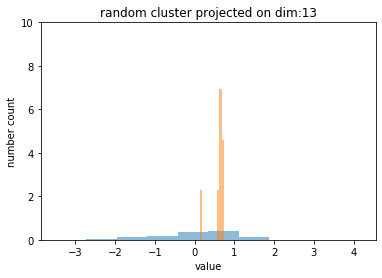

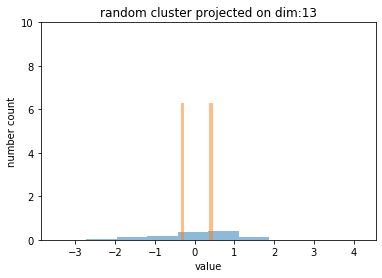

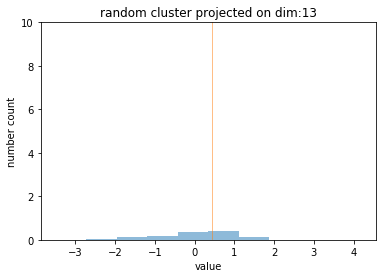

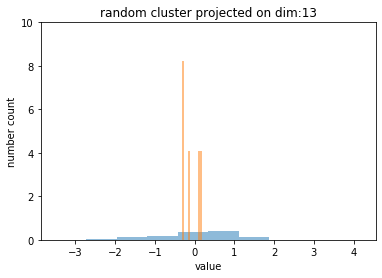

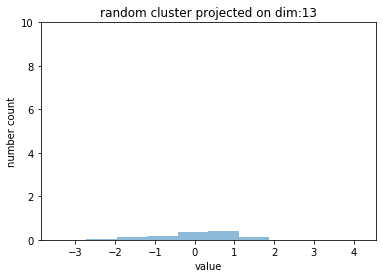

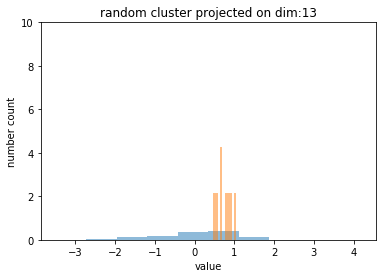

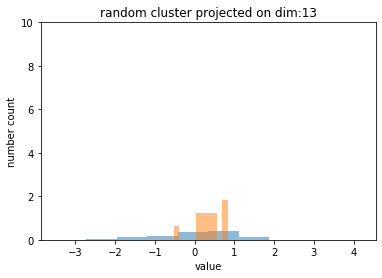

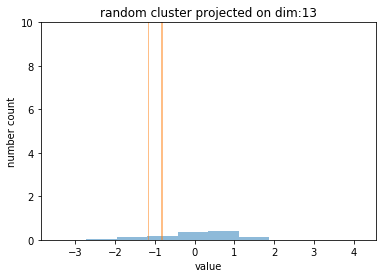

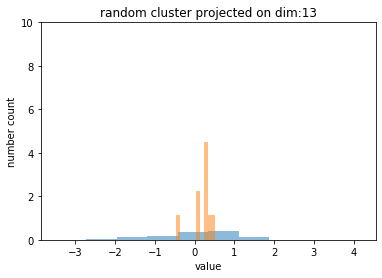

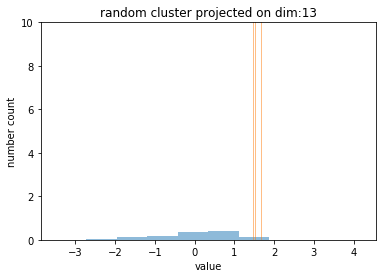

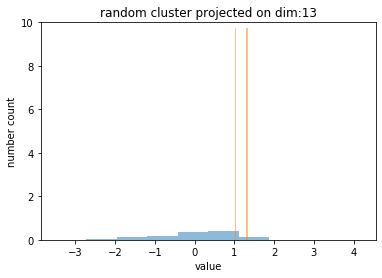

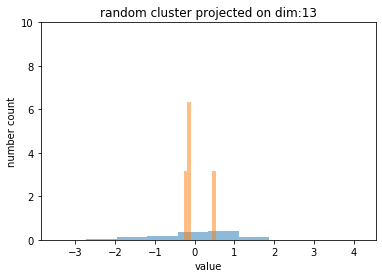

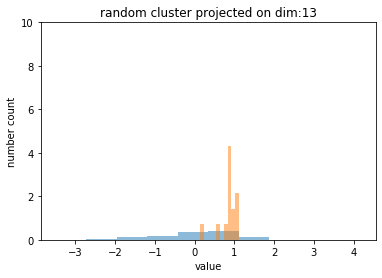

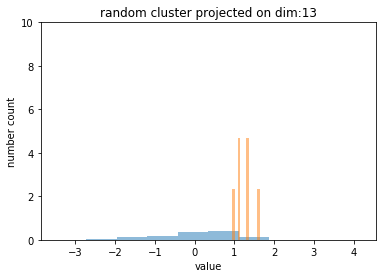

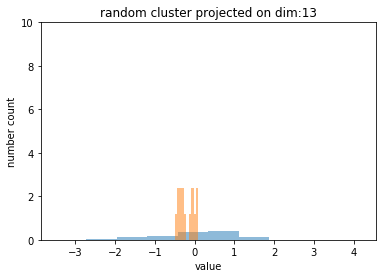

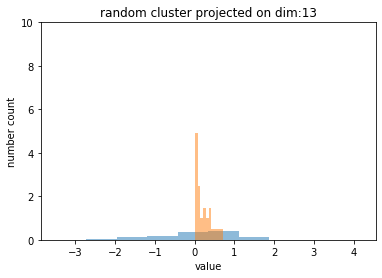

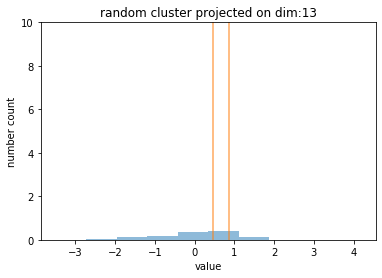

In [27]:
i=13
for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    plt.hist(v[i],density=True,alpha=0.5)
    plt.hist(v_occam[i,clust_idxs],density=True,alpha=0.5)
    plt.ylim(0,10)
    plt.title(f"random cluster projected on dim:{i}")
    plt.xlabel(f"value")
    plt.ylabel(f"number count")
    plt.show()

(array([3.80080481e-03, 4.71299796e-02, 1.51103107e-01, 1.89195617e-01,
        3.57529039e-01, 4.15554659e-01, 1.29227363e-01, 1.15713391e-02,
        7.60160961e-04, 2.53386987e-04]),
 array([-3.48485724, -2.71923401, -1.95361077, -1.18798753, -0.42236429,
         0.34325894,  1.10888218,  1.87450542,  2.64012865,  3.40575189,
         4.17137513]),
 <a list of 10 Patch objects>)

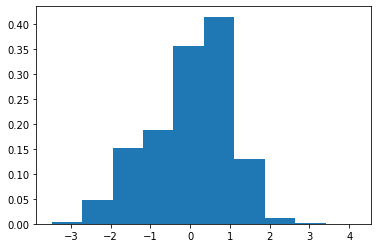

In [28]:
clust_idxs = z_occam.registry[cluster]
plt.hist(v[i],density=True,alpha=1)
#plt.hist(v_occam[i,clust_idxs],density=True,alpha=1)

In [29]:
np.var(v_centered_occam/np.std(v_centered_occam,axis=1)[:,None],axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [30]:
scaling_factor = np.std(v_centered_occam,axis=1)[:,None]
v_centered_occam_scaled = v_centered_occam/scaling_factor
v_occam_scaled = v_occam/scaling_factor
v_scaled = v/scaling_factor

In [74]:
np.std(v_centered_occam,axis=1)[None,:]

array([[2.53406888, 2.01177254, 1.50167732, 1.21800912, 1.09269911,
        1.03213604, 0.87347831, 0.80233781, 0.61330443, 0.5232034 ,
        0.45024539, 0.40801765, 0.35747257, 0.30473019, 0.20335333]])

In [31]:
v_occam_scaled[:,clust_idxs]

array([[-0.45694999,  0.82074451],
       [-0.61713339, -1.26579099],
       [ 0.06729241, -1.15908098],
       [-0.35063132,  0.97857112],
       [ 0.5588647 , -0.15606715],
       [-0.49532647,  2.31394369],
       [-0.7842829 , -1.04590224],
       [ 1.40195303,  1.38778966],
       [-2.18488771, -0.337528  ],
       [ 0.30850912,  2.03008549],
       [ 2.44902884,  0.91111459],
       [ 0.266785  , -0.29542769],
       [ 1.22123687,  1.80398229],
       [ 1.45627627,  2.92316097],
       [ 4.69872907,  1.12178531]])

In [43]:
dist = np.linalg.norm(v_occam_scaled[:,clust_idxs[0]]-v_occam_scaled[:,clust_idxs[5]])
print(dist)

4.617971492704413


[10.36892454  9.70557228  6.93332421 ... 15.0766857   8.14388035
 10.00042227]


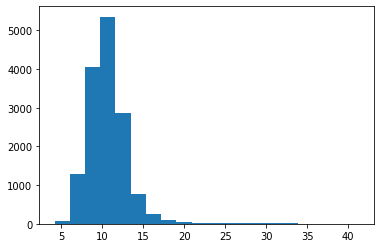

In [44]:
dist_random = np.array([np.linalg.norm(v_occam_scaled[:,clust_idxs[0]]-v_scaled[:,i]) for i in range(15000)])
plt.hist(dist_random,bins=20)
print(dist_random)

In [45]:
np.mean(dist_random<dist)

0.0002

In [46]:
clust_idxs = z_occam.registry["NGC 6791"]

### We perform an analoguous procedure on the labeled abundances

In [47]:
y_occam = vector.Vector(np.array([allStar_occam[param] for param in considered_parameters])[:,:n_data].T)
y_occam = vector.OccamLatentVector(occam_cluster_idxs,raw=y_occam(),order=1,interaction_only=False)

In [48]:
y_whitener = PCA(n_components=y.raw.shape[1],whiten=True)#z.raw.shape[1],whiten=True)
y_whitener.fit(y.centered())

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [49]:
y_pca = PCA(n_components=y.raw.shape[1])
y_pca.fit(y_occam.cluster_centered.whitened(y_whitener)())

PCA(copy=True, iterated_power='auto', n_components=15, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [50]:
scaling_factor = np.std(y_occam.cluster_centered(),axis=1)[:,None]

In [51]:
y2 =np.dot(y_pca.components_,y.centered.whitened(whitener)().T)
y2_centered_occam =np.dot(y_pca.components_,y_occam.cluster_centered.whitened(whitener)().T)
y2_occam =np.dot(y_pca.components_,y_occam.centered.whitened(whitener)().T)


(array([7.55812762e-04, 2.26743829e-03, 7.55812762e-04, 6.04649367e-03,
        3.77906381e-03, 5.29068934e-03, 1.28488170e-02, 1.43604425e-02,
        3.24999488e-02, 2.64534283e-02, 1.81395063e-02, 1.88953059e-02,
        1.51162552e-02, 4.23255147e-02, 7.40696507e-02, 1.43604325e-01,
        2.76627471e-01, 5.16975749e-01, 9.15289096e-01, 1.25086990e+00,
        1.40656731e+00, 1.61743903e+00, 1.59325289e+00, 1.26371872e+00,
        1.06040512e+00, 7.35405562e-01, 3.26511113e-01, 2.19185701e-01,
        8.38951582e-02, 4.53487657e-03]),
 array([-1.8396549 , -1.7540963 , -1.6685376 , -1.582979  , -1.4974202 ,
        -1.4118615 , -1.3263029 , -1.2407442 , -1.1551856 , -1.0696269 ,
        -0.9840682 , -0.89850956, -0.81295085, -0.7273922 , -0.64183354,
        -0.5562749 , -0.47071618, -0.38515753, -0.29959884, -0.21404018,
        -0.1284815 , -0.04292284,  0.04263584,  0.12819451,  0.21375318,
         0.29931185,  0.38487053,  0.47042918,  0.55598783,  0.64154655,
         0.72710

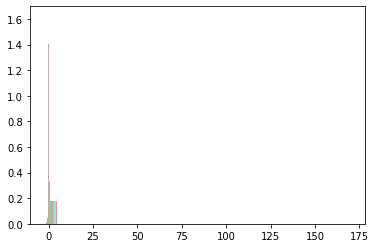

In [54]:
plt.hist(y_occam.cluster_centered()[:2],alpha=0.5,density=True,bins=30)
plt.hist(y.centered()[:,2],alpha=0.5,density=True,bins=30)

occam: 0.0035884616661785917
raw: 0.07210395485162735
ratio: 20.09327716419832
here


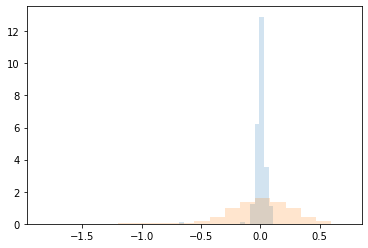

In [56]:
summarize_representation(y.centered()[:,2],y_occam.cluster_centered()[:,2],0.,0.)

occam: 39284.702252897296
raw: 8680.64185660085
ratio: 0.22096748502047364


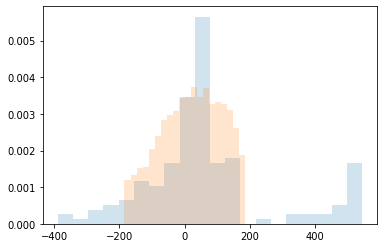

In [59]:
summarize_representation(y2[-1],y2_centered_occam[-1],0.1,0.1)

In [ ]:
z.centered.whitened(whitener)()

In [ ]:
print(inspect.getsource(vector))

In [ ]:
w_z_c = whitener.transform(z.centered)
w_z_occam_c = whitener.transform(z_occam.cluster_centered)
w_z_occam_centered = whitener.transform(z_occam.centered)

In [ ]:
plt.hist(w_z_c[:,-4],alpha=0.5,density=True)
plt.hist(w_z_occam_c[:,-4],alpha=0.5,density=True)
plt.hist(w_z_occam_centered[:,-4],alpha=0.5,density=True)


In [ ]:
pca = PCA(n_components=z.raw.shape[1])

In [ ]:
pca = PCA(n_components=z.raw.shape[1])
pca.fit(w_z_c[:200,:])
print(pca.explained_variance_)

In [ ]:
pca.fit(w_z_occam_c)
print(pca.explained_variance_)

In [ ]:
i=14
zc_b = np.dot(pca.components_,w_z_c.T)
zoccam_b = np.dot(pca.components_,w_z_occam_c.T)
zoccam_centered_b = np.dot(pca.components_,w_z_occam_centered.T)
summarize_representation(zc_b[i],zoccam_b[i],0.1,0.1)


In [ ]:
z()

In [ ]:
zc_b = vector.project(w_z_c,pca.components_[dim][None,:])
zoccam_c = vector.project(w_z_occam_centered,pca.components_[dim][None,:])


In [ ]:
plt.hist(zc_b,density=True,alpha=0.05)
plt.hist(zoccam_c,density=True,alpha=0.05)

In [ ]:
for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    plt.hist(zc_b,density=True,alpha=0.5)
    plt.hist(zoccam_c[clust_idxs],density=True,alpha=0.5)
    plt.show()

In [ ]:
for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    plt.hist(zc_b,density=True,alpha=0.5)
    plt.hist(zoccam_c[clust_idxs],density=True,alpha=0.5)
    plt.show()

In [ ]:
for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    plt.hist(zc_b,density=True,alpha=0.5)
    plt.hist(zoccam_c[clust_idxs],density=True,alpha=0.5)
    plt.show()

### Abundances

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
abundances_occam = []
elem = "C_FE"
elem_idx = considered_parameters.index(elem)

for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    abundances_occam.append(allStar_occam[clust_idxs][elem]-np.mean(allStar_occam[clust_idxs][elem]))
    #print(z_occam.dataset.allStar[clust_idxs][elem]-z_occam.dataset.allStar[clust_idxs][elem])
abundances_occam = np.array(flatten(abundances_occam))

In [ ]:
abundances_centered = []
for elem in considered_parameters:
    abundances_centered_elem = []
    for cluster in z_occam.registry:
        clust_idxs = z_occam.registry[cluster]
        abundances_centered_elem.append(allStar_occam[clust_idxs][elem]-np.mean(allStar_occam[clust_idxs][elem]))
    abundances_centered_elem = np.array(flatten(abundances_centered_elem))
    abundances_centered.append(abundances_centered_elem)


In [ ]:
y = vector.Vector(np.array([allStar[:n_data][combined_cut[:n_data]][param] for param in considered_parameters])[:,:n_data].T)


In [ ]:
y_occam = vector.Vector(np.array([allStar_occam[param] for param in considered_parameters])[:,:n_data].T)
y_occam = vector.OccamLatentVector(occam_cluster_idxs,raw=y_occam2(),order=1,interaction_only=False)

In [ ]:
y_occam2().

In [ ]:
y_occam().shape

In [ ]:
y_occam = vector.Vector(np.array(abundances_centered).T)

In [ ]:
y_occam()

In [ ]:
y_occam3.cluster_centered()

In [ ]:
summarize_representation(y.centered()[:,2],y_occam.cluster_centered()[:,2],0.2,0.2)


In [ ]:
summarize_representation(y.centered()[:,2],y_occam()[:,2],0.2,0.2)


In [ ]:
whitener = PCA(n_components=y.centered.shape[1],whiten=True)#z.raw.shape[1],whiten=True)
whitener.fit(y.centered)
w_y_c = whitener.transform(y.centered)
w_y_occam_c = whitener.transform(y_occam.raw)

In [ ]:
pca = PCA(n_components=w_y_c.shape[1])
pca.fit(w_y_occam_c)

In [ ]:
dim = 10
yc_b = vector.project(w_y_c,pca.components_[dim][None,:])
yoccam_b = vector.project(w_y_occam_c,pca.components_[dim][None,:])
summarize_representation(yc_b,yoccam_b,0.1,0.1)

In [ ]:
pca.components_.shape

# PRESENTATION STARTS HERE

# Fully unsupervised chemical tagging

**dataset: APOGEE -** large dataset of high-resolution, high signal-to-noise IR spectra.

**open cluster:** stars born from the same molecular cloud. Open-cluster are chemically-homogenous as the chemical composition of the molecular cloud is locked-in.

**chemical tagging:** Idea of identifying chemically identical stars based on chemical composition

What do APOGEE stars look like

In [ ]:
plt.plot(dataset.dataset["aspcap_interpolated"][0])
plt.title("Random stellar spectra")
plt.ylabel("intensity")
plt.xlabel("wavelength-ish")

We can take closer look.

In [ ]:
plt.plot(dataset.dataset["aspcap_interpolated"][0])
plt.title("Zoomed-in random stellar spectra ")
plt.ylabel("intensity")
plt.xlabel("wavelength-ish")
plt.xlim(1000,1500)

Spectra are very complicated, contain lots of absorption lines and involve non-LTE !!! Accurately modelling requires really well calibrated physics, beyond what we have, and thus extracting all chemical information is hard.

In [ ]:
dataset.allStar = allStar
#plt.plot(dataset.get_aspcap(*dataset.idx_to_prop(0),ext=1)[0],label="spectra")
plt.plot(dataset.dataset["aspcap_interpolated"][0],label="spectra")
plt.plot(dataset.get_aspcap(*dataset.idx_to_prop(0),ext=3)[0],label="fit")
plt.ylabel("intensity")
plt.xlabel("wavelength-ish")
plt.legend()
plt.title("spectra and it's modelling fit")
plt.xlim(2100,2200)
plt.ylim(0.8,1.2)


### How to find chemically identical stars without any stellar models?

# Step 1: Obtain a lower dimensional representation of spectra

**Solution**: Principal component analysis


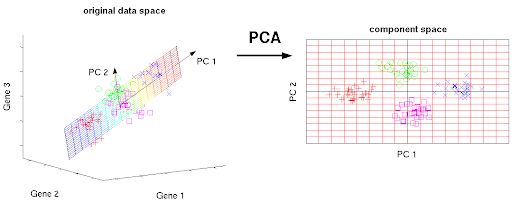

### Apply this to the spectra

In [ ]:
plt.plot(compressor.components_[0],label="1st PC")
plt.plot(compressor.components_[1],label="2nd PC")
plt.plot(compressor.components_[2],label="3rd PC")
plt.ylabel("intensity")
plt.xlabel("wavelength-ish")
plt.title("First few PCA components")
plt.legend()
plt.xlim(2100,2200)

In [ ]:
dataset.allStar = allStar
#plt.plot(dataset.get_aspcap(*dataset.idx_to_prop(0),ext=1)[0],label="spectra")
plt.plot(dataset.dataset["aspcap_interpolated"][0],label="spectra")
plt.plot(reconstructed_dataset[0],label="reconstructed")
#plt.plot(dataset.get_aspcap(*dataset.idx_to_prop(5),ext=3)[0],label="fit")
plt.ylabel("intensity")
plt.xlabel("wavelength-ish")
plt.legend()
plt.title("spectra and it's PCA fit")
plt.xlim(2100,2200)
plt.ylim(0.8,1.2)


The fit using PCA is quite good, even with only **20** components it's noticeably better then the physical fit!!!

**But how to get the information out of this spectra ??**

In [ ]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))
    plt.xlabel(considered_parameters[i])
    plt.ylabel(f"{considered_parameters[i]} pred")

    plt.legend()
    plt.show()

#### We see that, after applying PCA, we obtained a lower-dimensional latent representation of stellar spectra in which  each stellar parameter is well represented by a linear vector, ie, directions in our latent space match well with stellar parameters.

How can we exploit this, an identify chemically similar stars without any supervision whatsoever?

Answer:
1. Whiten our PCA representation using the full dataset of stars. This is a rescaling of our data that makes it such that our latent/PCA data looks like a unit gaussian

2. Then take an open-cluster dataset (containing one open-cluster or multiple recentered open-clusters) and apply (again) PCA on the latents of this dataset. Because, after whitening, the variance of the full dataset after projection along any direction in the latent space should be 1, the variances along a direction in our only open-cluster dataset basically corresponds to the ratio this direction varies within the full stellar dataset vs within an open custer. The lowest PC components (ie lowest variance directions) thus correspond exactly to those factors which vary much less between stars in an open-cluster than between random stars. Exactly what we want.

3. We can then measure chemical similarity between stars by measuring scaled latent space distances, where dimensions are scaled according to how small their variance is in an open clusters relative to the full stellar population.

### But does this work???

We plot the positions in the lowest PCA components of stars in open-clusters.

In [ ]:
i=14
for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    plt.hist(v[i],density=True,alpha=0.5,label="background population")
    plt.hist(v_occam[i,clust_idxs],density=True,alpha=0.5,label="an open cluster")
    plt.ylim(0,3)
    plt.title(f"random cluster projected on dim:{i}")
    plt.xlabel(f"value")
    plt.ylabel(f"number count")
    plt.legend()
    plt.show()

In [ ]:
i=13
for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    plt.hist(v[i],density=True,alpha=0.5,label="background population")
    plt.hist(v_occam[i,clust_idxs],density=True,alpha=0.5,label="an open cluster")
    plt.ylim(0,3)
    plt.title(f"random cluster projected on dim:{i}")
    plt.xlabel(f"value")
    plt.ylabel(f"number count")
    plt.legend()
    plt.show()

### Caveats:

- I'm only using 190 stars in open clusters. So I am limited in how many dimensions of my PCA I can keep without overfitting. I need to play around and actually ascertain that I'm not overfitting in the shown examples. (This will probably involve some form of bootstrapping). I'm confident-ish that overfitting isn't too large of an issue in the shown images.

- I've been a little bit less restrictive on my dataset cuts for my open-cluster stars (because there are so few of them). I need to really make sure that my cuts are not introducing differences in the factors of variation between both datasets which are not in the raw data (that the method could be leveraging when it shouldn't).

- The hope is that with more open-clusters discovered by GAIA, and targetted by APOGEE, we can afford to run the PCA on larger-dimensional latent spaces and improve our methods results even further.



### Aside on overfitting

If we have an n-dimensional latent. Then we are estimating a covariance matrix containing $n^2$ numbers. Each star latent contains n numbers so we need at the bare-minimum n stars to estimate the covariance matrix. However real data is messy and you need a fair few more stars. The number of high-quality open cluster stars is the limit of our method.

In [65]:
np.std(y[:,2])

TypeError: 'Vector' object is not subscriptable

In [79]:
np.std(y.centered()[:,7])

0.07014338

In [80]:
np.std(y_astronn.centered()[:,7])

0.07480218

(array([3.000e+00, 1.000e+00, 3.000e+00, 1.575e+03, 9.531e+03, 2.131e+03,
        1.607e+03, 5.740e+02, 3.400e+01, 5.000e+00]),
 array([-0.3692382 , -0.2929492 , -0.21666019, -0.14037119, -0.06408218,
         0.01220682,  0.08849583,  0.16478483,  0.24107383,  0.31736284,
         0.39365184], dtype=float32),
 <a list of 10 Patch objects>)

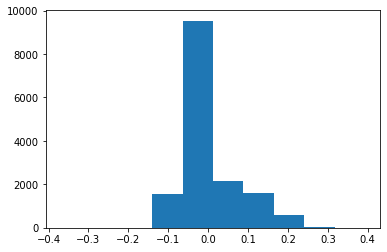

In [81]:
plt.hist(y.centered()[:,7])

(array([ 157., 4557., 5028., 2667., 1250.,  925.,  597.,  200.,   61.,
          22.]),
 array([-0.1472329 , -0.0973498 , -0.04746669,  0.00241642,  0.05229953,
         0.10218263,  0.15206574,  0.20194885,  0.25183195,  0.30171508,
         0.35159817], dtype=float32),
 <a list of 10 Patch objects>)

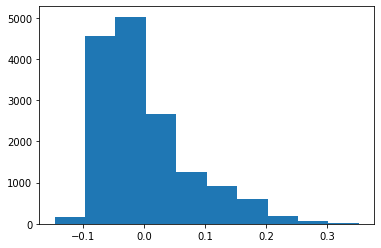

In [82]:
plt.hist(y_astronn.centered()[:,7])

occam: 0.0024221765343099833
raw: 0.0024221765343099833
ratio: 1.0


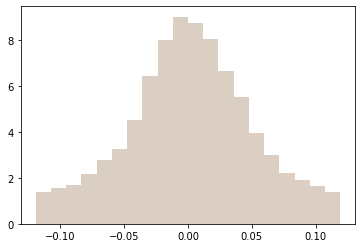

In [153]:
summarize_representation(y_astronn.centered()[:,5],y_astronn.centered()[:,5],0.1,0.1)

occam: 0.0024221765343099833
raw: 0.0068952906876802444
ratio: 2.846733331680298


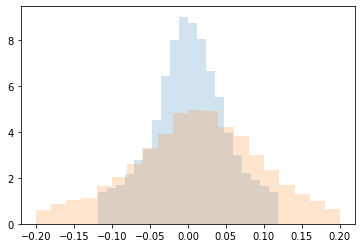

In [159]:
summarize_representation(y.centered()[:,5],y_astronn.centered()[:,5],0.1,0.1)

occam: 0.0006138717872090638
raw: 0.0009428613702766597
ratio: 1.5359255075454712


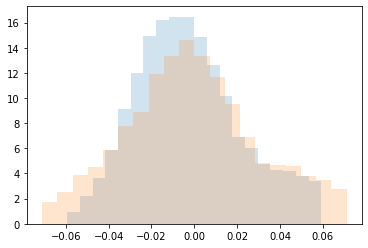

In [167]:
summarize_representation(y.centered()[:,11],y_astronn.centered()[:,11],0.05,0.05)

In [169]:
considered_parameters[11]

'Ni_FE'

In [92]:
print(inspect.getsource(summarize_representation))

def summarize_representation(z_all, z_occam, percentage_all=0.1, percentage_occam=0.1,plot_cut=True):
    """Function to plot the histogram summary of a method
    z_all: np.array
        representation of full dataset
    z_occam: np.array
        representation of chemical clusters
    percentage_all: float
        Fraction of outliers in full dataset to cut. Used for result to not depend on outliers.
    percentage_occam: float
            Fraction of outliers in occam dataset to cut. Used for result to not depend on outliers.
    plot_cut: boolean
        whether to plot the raw or cut distribution
    """
    n_all = round(len(z_all)*percentage_all)
    n_occam = round(len(z_occam)*percentage_occam)
    sorted_all = z_all[np.abs(z_all).argsort()]
    sorted_occam = z_occam[np.abs(z_occam).argsort()]
    if n_occam!=0:
        var_occam = np.var(sorted_occam[:-n_occam])
    else:
        var_occam = np.var(sorted_occam)
    if n_all!=0:
        var_raw = np.var(sorted_all[:-n_all])

In [93]:
    sorted_all = z_all[np.abs(z_all).argsort()]

NameError: name 'z_all' is not defined

In [178]:
a = 1.5
b = 3
x = np.random.randn(8)*5
y = np.random.randn(8)*3+a*x+b

In [ ]:
plt.scatter(x,y,marker="x")
plt.plot([-6,12],[-6,15],"r")
plt.plot([-6,15],[0,20],"g")
plt.plot([-9,15],[0,20],"purple")

plt.xlabel("inputs")
plt.ylabel("outputs")
plt.title("data")
plt.xlim(-6,10.5)